Si vous utilisez Google Colab, exécutez d'abord la cellule ci-dessous. La cellule présume que le code du TP1 (le dossier prog) se trouve dans MyDrive/IFT780/TP1/. Si ce n'est pas le cas, changez le chemin pour le vôtre. 

In [ ]:
# à exécuter uniquement sur les serveurs de google colab
from google.colab import drive
drive.mount('/content/drive')
!cp -r drive/MyDrive/IFT780/TP1/prog/* .

# TP1: Classifieur linéaire, fonction de perte **Entropie croisée**

In [4]:
import random
import numpy as np
from utils.data_utils import load_CIFAR10
from utils.data_utils import display_images

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# pour automatiquement recharger les modules externes
# voir http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## CIFAR-10 Chargement des données et prétraitement

### **TODO** assurez-vous d'exécuter le script *./get_datasets.sh* au moins une fois dans un terminal.

In [5]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500, num_batch=200):
    """
    Charger la banque de données CIFAR-10, prétraiter les images et ajouter une dimension pour le biais.
    
    Input :
    - num_training : nombre d'images à mettre dans l'ensemble d'entrainement
    - num_validation : nombre d'images à mettre dans l'ensemble de validation
    - num_test : nombre d'images à mettre dans l'ensemble de test
    - num_dev : d'images à mettre dans l'ensemble dev
    
    Output :
    - X_train, y_train : données et cibles d'entrainement
    - X_val, y_val: données et cibles de validation
    - X_test y_test: données et cibles de test 
    - X_dev, y_dev: données et cibles dev
    - X_batch, y_batch: batch de données et de cibles 
    """
    # Charger les données CIFAR-10
    cifar10_dir = 'datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test, label_names = load_CIFAR10(cifar10_dir)
  
    # Séparer en ensembles d'entraînement, de validation, de test et de dev
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    mask = range(num_batch)
    X_batch = X_train[mask]
    y_batch = y_train[mask]
    
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    X_batch = np.reshape(X_batch, (X_batch.shape[0], -1))

    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev, X_batch, y_batch, label_names 

def preprocess_CIFAR10_data(X):

    # Normalisation
    X_mean = np.mean(X, axis = 0)
    X_ = X - X_mean

    # Ajout du biais
    X_ = np.hstack([X_, np.ones((X.shape[0], 1))])
    
    return X_

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)
batch data shape:  (200, 3073)
batch labels shape:  (200,)
CIFAR10 est un jeu de données d'images RGB 32x32x3 séparées en 10 classes
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


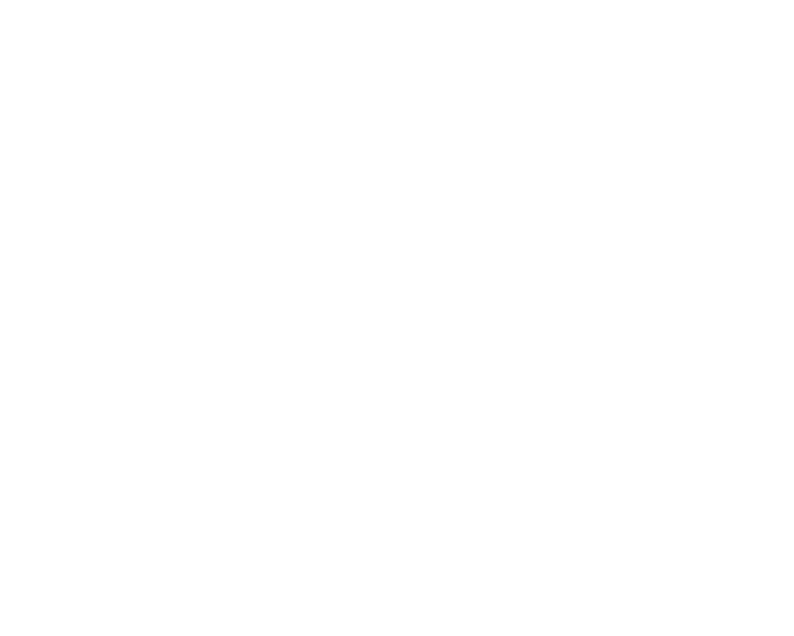

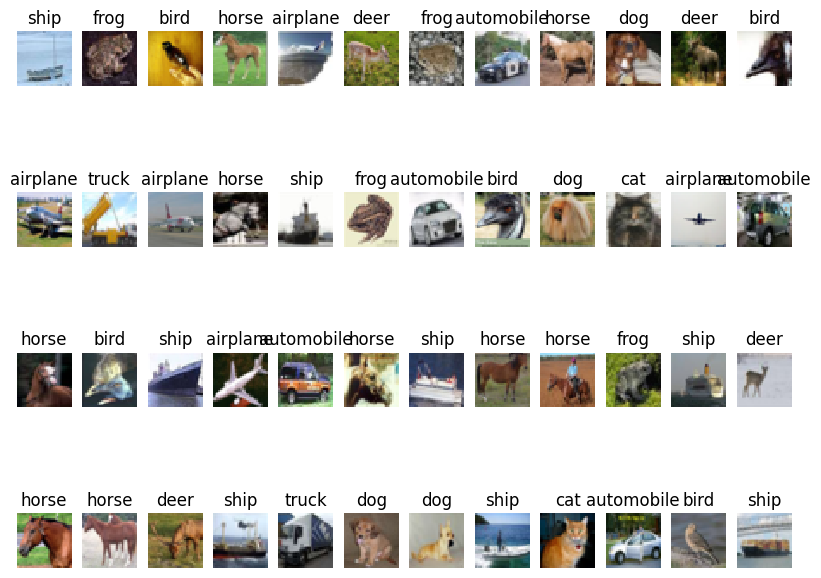

In [6]:
Data_train, y_train, Data_val, y_val, Data_test, y_test, Data_dev, y_dev, Data_batch, y_batch, label_names = get_CIFAR10_data()
X_train, X_val, X_test, X_dev, X_batch, = (preprocess_CIFAR10_data(Data) for Data in (Data_train, Data_val, Data_test, Data_dev, Data_batch))

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)
print('batch data shape: ', X_batch.shape)
print('batch labels shape: ', y_batch.shape)


    
print("CIFAR10 est un jeu de données d'images RGB 32x32x3 séparées en 10 classes")
print(label_names)

display_images(Data_train, y_train, label_names)

## Question 1

Les prochaines étapes consistent à implanter le calcul de **l'entropie croisée** et de son **gradient**.   Vous commencerez avec une version naïve impliquant une boucle *for* sur l'ensemble des éléments d'une batch pour ensuite implanter une version vectorisée.   Mais avant de commencer à coder, veuillez donner ici la formule de l'entropie croisée et du gradient pour une mini-batch de 500 données contenue dans le tableau

$$X \in R^{500\times 3073}$$

et une matrice de poids $$W \in R^{3073\times 10}$$ 

où 3073 est la dimensionnalité des données et 10 est le nombre de classes.

**Votre Réponse:** 

$$Loss = -\frac{1}{500}\sum_{n=1}^{500} ln\left(\frac{e^{\vec{W^T_{t_n}}\cdot\vec{X_n}}}{\sum_{j=1}^{10}e^{\vec{W^T_{j}}\cdot\vec{X_n}}}\right) + \frac{1}{2}\lambda ||W||^2$$

où $t_n$ est la classe prédite pour $\vec{X_n}$ et $\lambda$ est le terme de regularisation L2. Nous supposons ici qu'un 1 a été ajouté à la fin de chaque $\vec{X_n}$ et qu'une ligne a été ajouté à $W$ pour tenir compte des biais.

Soit

$$S = \frac{e^{X\cdot W}}{\sum_{j=1}^{10}e^{X\cdot W}}$$

une matrice $500\times 10$ qui représente la sortie du softmax et $T$ est une matrice $500\times 10$ où chaque ligne est un vecteur one-hot pour la classe vérité terrain pour $\vec{X_n}$.

$$dW = \frac{1}{500} X^T \cdot (S - T) + \lambda W$$


**NOTE IMPORTANT** : la réponse à cette question doit contenir un minimum de boucles (sommation), au bénéfice de multiplications matricielles et vectorielles.   Voir les notes de cours et https://info.usherbrooke.ca/pmjodoin/cours/ift603/softmax_grad.html pour vous aider...

## Classifieur linéaire SOFTMAX

Le code pour cette section est dans le fichier **utils/loss.py**. 

La fonction `softmax_ce_naive_forward_backward` estime la perte (et le gradient) à l'aide de boucles `for` qui itèrent sur chaque donnée de la mini-batch.  


Commençons par tester la **forward pass + l'entropie croisée**.  Pour l'instant, ignorons la rétro-propagation.

In [13]:
##############################################################################
# TODO: Implémenter le calcul de perte de façon naive avec des boucles dans  #
#  la fonction softmax_ce_naive_forward_backward située dans le fichier      #
#  utils.loss.                                                               #
#  On commence par UNE image et UNE cible                                    #
##############################################################################

from utils.loss import softmax_ce_naive_forward_backward
import time

# Matrice de poids aléatoires + 1 donnée à tester
np.random.seed(0)
W = np.random.randn(3073, 10) * 5e-4
X_rnd = np.random.randn(1, 3073) * 5
y_rnd = np.uint32(np.ones(1))
loss, _ = softmax_ce_naive_forward_backward(X_rnd, W, y_rnd, 0.0)

# La loss suivante est celle que vous devriez obtenir
target_loss = 2.276854
loss_error = np.abs(loss - target_loss)
if loss_error < 1e-5:
    print("Bravo!")
else:
    print("Il y a un bug...")
print('loss error: %f' % loss_error)

Bravo!
loss error: 0.000000


In [14]:
##############################################################################
# TODO: Implémenter le calcul de perte de façon naive avec des boucles dans  #
#  la fonction softmax_ce_naive_forward_backward située dans le fichier      #
#  utils.loss.                                                               #
#  Maintenant on test avec N=200 images et autant de cibles                  #
##############################################################################

from utils.loss import softmax_ce_naive_forward_backward
import time

# Matrice de poids aléatoires + 500 données 
np.random.seed(0)
W = np.random.randn(3073, 10) * 1e-4
loss, _ = softmax_ce_naive_forward_backward(X_batch, W, y_batch, 0.0)

target_loss = 2.356459
loss_error = np.abs(loss - target_loss)
if loss_error < 1e-5:
    print("Bravo!")
else:
    print("Il y a un bug...")
print('loss error: %f' % loss_error)


Bravo!
loss error: 0.000000


## Question 2:
Pourquoi s'attend-on que la loss soit approximativement -np.log(1/nb_classes))?

**Votre réponse:**

La sortie du softmax est donnée par:

$$S_i = \frac{e^{W^T_i \vec{x} + b_i}}{\sum_{j=1}^{10}e^{W^T_j \vec{x} + b_j}}$$

Si le modèle n'a pas encore été entraîné et que les poids ont été initialisés aléatoirement, alors $e^{W^T_i \vec{x} + b_i}$ est environ égal pour tout les $i$ donc $S_i$ (qui donne la probabilité pour la classe $i$) vaut environ 1/nb_classes. Étant donnée la formule pour la loss fournie plus haut et en supposant que les poids sont initialement petits alors on voit que la loss est approximativement -np.log(1/nb_classes)). 


In [15]:
###################################################################################
#  Vérification simple: s'assurer que l'entropie-croisée soit proche de           #
#  -log(1/nb_classes)                                                             #
###################################################################################

from utils.loss import softmax_ce_naive_forward_backward
import time

# Matrice de poids aléatoires + 500 données 
W = np.random.randn(3073, 10) * 1e-4
loss, _ = softmax_ce_naive_forward_backward(X_batch, W, y_batch, 0.0)

# La loss d'un modèle non-entrainé devrait s'approcher de -log(0.1).
print('Softmax loss: %f' % loss)
print('Sanity check: %f' % (-np.log(0.1)))

Softmax loss: 2.339132
Sanity check: 2.302585


## Rétro-propagation

Maintenant, passons à la **rétro-propagation**!

In [16]:
##############################################################################
# TODO: Implémenter le calcul de perte ET DE LA RÉTROPROPAGATION de façon    #
#       naive avec des boucles dans la fonction                              #
#       softmax_ce_naive_forward_backward située dans le fichier utils.loss  #
#                                                                            #
#  On commence par UNE image et UNE cible                                    #
##############################################################################

from utils.loss import softmax_ce_naive_forward_backward
import time

# Matrice de poids aléatoires + une donnée
np.random.seed(0)
W = np.random.randn(3073, 10) * 1e-4
X_rnd = np.random.randn(1, 3073)
y_rnd = np.uint32(np.ones(1))
loss, dW = softmax_ce_naive_forward_backward(X_rnd, W, y_rnd, 0.0)

# La loss suivante est celle que vous devriez obtenir
target_loss = 2.30114875
loss_error = np.abs(loss - target_loss)
if loss_error < 1e-5:
    print("Bravo pour la loss!")
else:
    print("Il y a un bug au niveau de la loss...")
print('loss error: %f' % loss_error)

# Le gradient suivant est celui que vous devriez obtenir pour les 3 premiers poids
target_dW = np.array([-0.1279744 ,  1.15786877, -0.12847105])
dW_error = np.mean(np.abs(dW[0,0:3]-target_dW))
if dW_error < 1e-7:
    print("Bravo pour le gradient!")
else:
    print("Il y a un bug au niveau du gradient...")
print('gradient error %f' % dW_error)

Bravo pour la loss!
loss error: 0.000000
Bravo pour le gradient!
gradient error 0.000000


In [17]:
##############################################################################
# TODO: Implémenter le calcul de perte ET DE LA RÉTROPROPAGATION de façon    #
#       naive avec des boucles dans la fonction                              #
#       softmax_ce_naive_forward_backward située dans le fichier utils.loss  #
#                                                                            #
#  Maintenant on test avec N=200 images et autant de cibles                  #
##############################################################################

from utils.loss import softmax_ce_naive_forward_backward
import time

# Matrice de poids aléatoires + 500 données
np.random.seed(1)
W = np.random.randn(3073, 10) * 1e-4
loss, dW = softmax_ce_naive_forward_backward(X_batch, W, y_batch, 0.0)
print(dW[0,0:4])
# La loss suivante est celle que vous devriez obtenir
target_loss = 2.35680883
loss_error = np.abs(loss - target_loss)
if loss_error < 1e-5:
    print("Bravo pour la loss!")
else:
    print("Il y a un bug au niveau de la loss...")
print('loss error: %f' % loss_error)

# Le gradient suivant est celui que vous devriez obtenir pour les 3 premiers poids
target_dW = np.array([-1.68817739, -1.37204569, -0.46158773, 1.9206649])
dW_error = np.mean(np.abs(dW[0,0:4]-target_dW))
if dW_error < 1e-7:
    print("Bravo pour le gradient!")
else:
    print("Il y a un bug au niveau du gradient...")
print('gradient error %f' % dW_error)

[-1.68817739 -1.37204569 -0.46158773  1.9206649 ]
Bravo pour la loss!
loss error: 0.000000
Bravo pour le gradient!
gradient error 0.000000


### Encore quelques vérifications d'usage
En principe, à ce point-ci, le calcul de l'entropie croisée (et de son gradient) via la fonction *softmax_ce_naive_forward_backward* devrait fonctionner.  Mais avant de passer à la prochaine étape il nous reste deux vérifications à faire : s'assurer que la **régularisation** fonctionne et passer le teste du **gradient numérique**

In [18]:
##############################################################################
# Vérifions que le fait d'augmenter le terme de régularisation L2            #
# augmente la loss...                                                        #
##############################################################################
success = True

# Matrice de poids aléatoires + 500 données
np.random.seed(1)
W = np.random.randn(3073, 10) * 1e-4
prev_loss, _ = softmax_ce_naive_forward_backward(X_dev, W, y_dev, 0.0)

reg = 1e2
for i in range(10):
    loss, _ = softmax_ce_naive_forward_backward(X_dev, W, y_dev, reg)
    print(loss)
    if loss <= prev_loss:
        success = False
    prev_loss = loss
    reg *= 1.2
    
if success:
    print("Bravo!")
else:
    print('Erreur!')


2.383044951677497
2.3835477981282462
2.3841512138691456
2.384875312758225
2.3857442314251203
2.386786933825394
2.388038176705723
2.3895396681621177
2.391341457909791
2.3935036056069996
Bravo!


In [19]:
##############################################################################
# Maintenant testons le gradient numérique avec et sans régularisation       #
# Les erreurs relatives devraient être inférieures à 1e-6                    #
##############################################################################
from utils.gradients import check_gradient_sparse

print("\n------------\nGradient check : reg=0\n------------\n")
check_gradient_sparse(softmax_ce_naive_forward_backward, W, X_dev, y_dev, 0.0)

# Faire un autre test de gradients avec régularisation 
print("\n------------\nGradient check : reg=1e-2\n------------\n")
check_gradient_sparse(softmax_ce_naive_forward_backward, W, X_dev, y_dev, 1e2)


------------
Gradient check : reg=0
------------

numerical: 0.960584, analytic 0.960584, relative error: 4.686851e-10
numerical: -0.748709, analytic -0.748709, relative error: 1.066356e-09
numerical: -1.879089, analytic -1.879089, relative error: 2.494994e-11
numerical: 0.319069, analytic 0.319069, relative error: 1.359479e-09
numerical: -0.332231, analytic -0.332231, relative error: 2.533507e-09
numerical: -0.226552, analytic -0.226552, relative error: 1.640406e-09
numerical: -1.183807, analytic -1.183807, relative error: 7.559964e-10
numerical: -2.592471, analytic -2.592471, relative error: 1.193138e-10
numerical: 0.887372, analytic 0.887372, relative error: 6.698083e-10
numerical: 1.486394, analytic 1.486394, relative error: 5.462128e-10

------------
Gradient check : reg=1e-2
------------

numerical: 0.628618, analytic 0.603261, relative error: 2.058379e-02
numerical: 1.167565, analytic 1.156585, relative error: 4.724274e-03
numerical: 4.569156, analytic 4.557079, relative error:

## Softmax et gradients vectorisés
Passons maintenant aux choses sérieuses. Vous devez ici coder la version vectorisée de l'entropie croisée et du gradient dans la fonction **softmax_ce_forward_backward**.  Ce code s'apparente à la réponse que vous avec donné au début.

In [20]:
##############################################################################
# TODO: Implémenter le calcul de perte et du gradient de façon vectorielle   #
# dans la fonction softmax_ce_forward_backward située dans le fichier        #
# utils.loss.                                                                #
# Les deux versions devraient calculer les mêmes résultats, mais la version  #
# vectorielle devrait être BEAUCOUP PLUS RAPIDE.                             #
##############################################################################
start = time.time()
loss_naive, grad_naive = softmax_ce_naive_forward_backward(X_dev, W, y_dev, 0.00001)
end = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, end - start))

from utils.loss import softmax_ce_forward_backward
start = time.time()
loss_vectorized, grad_vectorized = softmax_ce_forward_backward(X_dev, W, y_dev, 0.00001)
end = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, end - start))

grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
loss_diff = np.abs(loss_naive - loss_vectorized)
if loss_diff < 1e-7:
    print('bravo pour la loss!')
else:
    print('il y a un bug au niveau de la loss')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))

if grad_difference < 1e-7:
    print('bravo pour le gradient !')
else:
    print('il y a un bug au niveau du gradient')
print('Gradient difference: %f' % grad_difference)

naive loss: 2.380531e+00 computed in 13.176804s
vectorized loss: 2.380531e+00 computed in 0.004778s
bravo pour la loss!
Loss difference: 0.000000
bravo pour le gradient !
Gradient difference: 0.000000


## Entraînement
À l'aide de la classe **LinearClassifier** ainsi que de la fonction vectorisée **softmax_ce_forward_backward** que vous venez de coder, vous devez maintenant entraîner un réseau de neurones multiclasses linéaire à l'aide d'une **descente de gradient**.

train loss for iteration 0 : 
5.641128942989222
train loss for iteration 1 : 
5.799819726997308
train loss for iteration 2 : 
5.608685437455156
train loss for iteration 3 : 
5.361112120678917
train loss for iteration 4 : 
5.325578028103585
train loss for iteration 5 : 
5.304681112157183
train loss for iteration 6 : 
5.461275169997071
train loss for iteration 7 : 
5.179626563650782
train loss for iteration 8 : 
5.197480545685337
train loss for iteration 9 : 
5.256747108801402
train loss for iteration 10 : 
4.8166934908222485
train loss for iteration 11 : 
5.411734935337528
train loss for iteration 12 : 
4.956506200839676
train loss for iteration 13 : 
4.9813996582510995
train loss for iteration 14 : 
5.026014901038629
train loss for iteration 15 : 
4.904080167142556
train loss for iteration 16 : 
5.171358447810921
train loss for iteration 17 : 
5.3345968478048125
train loss for iteration 18 : 
5.010570807149863
train loss for iteration 19 : 
5.371076815998284
train loss for iteration 20

train loss for iteration 176 : 
3.650306174713186
train loss for iteration 177 : 
3.893178808626622
train loss for iteration 178 : 
3.707342133244086
train loss for iteration 179 : 
3.5634163446039353
train loss for iteration 180 : 
3.8598538949828405
train loss for iteration 181 : 
3.696678948768921
train loss for iteration 182 : 
3.763080253146721
train loss for iteration 183 : 
3.7472351710115914
train loss for iteration 184 : 
3.6668400950914664
train loss for iteration 185 : 
3.382819548945269
train loss for iteration 186 : 
3.5578702594419935
train loss for iteration 187 : 
3.406198081415426
train loss for iteration 188 : 
3.6006361296024623
train loss for iteration 189 : 
3.230777454984635
train loss for iteration 190 : 
3.6215464918121
train loss for iteration 191 : 
3.763545714624922
train loss for iteration 192 : 
3.7656853116987694
train loss for iteration 193 : 
3.1613177460347637
train loss for iteration 194 : 
3.72798592883885
train loss for iteration 195 : 
3.27491401564

train loss for iteration 398 : 
3.1912010761940333
train loss for iteration 399 : 
3.1392185870203444
train loss for iteration 400 : 
3.0748822647265444
train loss for iteration 401 : 
3.1587890672981995
train loss for iteration 402 : 
3.2927216097946554
train loss for iteration 403 : 
3.175168854831096
train loss for iteration 404 : 
3.297721591468876
train loss for iteration 405 : 
3.199323487802582
train loss for iteration 406 : 
3.21044972319158
train loss for iteration 407 : 
3.1533483310380057
train loss for iteration 408 : 
3.1350881941203994
train loss for iteration 409 : 
3.336797348723981
train loss for iteration 410 : 
3.3326753182678632
train loss for iteration 411 : 
3.174550673529133
train loss for iteration 412 : 
3.270204205944502
train loss for iteration 413 : 
3.338498546783146
train loss for iteration 414 : 
3.018954270505905
train loss for iteration 415 : 
3.160109745293023
train loss for iteration 416 : 
3.360559094752595
train loss for iteration 417 : 
3.117496732

train loss for iteration 567 : 
2.987909013701411
train loss for iteration 568 : 
2.846016575332953
train loss for iteration 569 : 
2.9321248633925188
train loss for iteration 570 : 
2.872911107604323
train loss for iteration 571 : 
2.92819750790859
train loss for iteration 572 : 
2.936034612405128
train loss for iteration 573 : 
3.0599084591079344
train loss for iteration 574 : 
2.9673998565239037
train loss for iteration 575 : 
2.991401764741524
train loss for iteration 576 : 
2.888302527796575
train loss for iteration 577 : 
3.2690503860390407
train loss for iteration 578 : 
3.381232146520342
train loss for iteration 579 : 
3.299851706970238
train loss for iteration 580 : 
3.048536884922404
train loss for iteration 581 : 
3.224495797858444
train loss for iteration 582 : 
3.0470170097219897
train loss for iteration 583 : 
3.0006153452993978
train loss for iteration 584 : 
3.006040291760098
train loss for iteration 585 : 
3.0363867692939963
train loss for iteration 586 : 
3.0613677241

train loss for iteration 740 : 
3.0116480039354827
train loss for iteration 741 : 
2.818461471545976
train loss for iteration 742 : 
3.002650117361186
train loss for iteration 743 : 
3.258723754504424
train loss for iteration 744 : 
2.6976120741963676
train loss for iteration 745 : 
2.944728491023906
train loss for iteration 746 : 
2.9595368416349124
train loss for iteration 747 : 
2.796344972698194
train loss for iteration 748 : 
2.7576766510094908
train loss for iteration 749 : 
2.8276618698062674
train loss for iteration 750 : 
3.0838867428516505
train loss for iteration 751 : 
3.195625084338318
train loss for iteration 752 : 
2.87590103254236
train loss for iteration 753 : 
2.5899509280438395
train loss for iteration 754 : 
2.916083094618627
train loss for iteration 755 : 
2.7347893437565576
train loss for iteration 756 : 
3.0519323012624957
train loss for iteration 757 : 
2.860383746631535
train loss for iteration 758 : 
2.97239019817398
train loss for iteration 759 : 
2.839373292

train loss for iteration 920 : 
2.836485353109207
train loss for iteration 921 : 
2.7060249463056563
train loss for iteration 922 : 
3.14591864081505
train loss for iteration 923 : 
3.0083876675227703
train loss for iteration 924 : 
2.8799113919754102
train loss for iteration 925 : 
2.7879688161503675
train loss for iteration 926 : 
2.5947001342653198
train loss for iteration 927 : 
2.6494493364304916
train loss for iteration 928 : 
2.5993809228273146
train loss for iteration 929 : 
2.6212130381341185
train loss for iteration 930 : 
2.798663482590048
train loss for iteration 931 : 
2.781059635752351
train loss for iteration 932 : 
2.7696302240169763
train loss for iteration 933 : 
2.675882562705307
train loss for iteration 934 : 
2.837335552002798
train loss for iteration 935 : 
2.471861553957165
train loss for iteration 936 : 
2.802392925431058
train loss for iteration 937 : 
2.7494752644702323
train loss for iteration 938 : 
2.8058126292790218
train loss for iteration 939 : 
3.080254

train loss for iteration 1097 : 
2.577293252172674
train loss for iteration 1098 : 
2.568156781954738
train loss for iteration 1099 : 
2.6956378500076728
train loss for iteration 1100 : 
2.664504113717161
train loss for iteration 1101 : 
2.7507345037382867
train loss for iteration 1102 : 
2.7743420749843555
train loss for iteration 1103 : 
2.8960746683601797
train loss for iteration 1104 : 
2.515580849657297
train loss for iteration 1105 : 
2.7855985667102345
train loss for iteration 1106 : 
2.8180811133449435
train loss for iteration 1107 : 
3.0862275278316815
train loss for iteration 1108 : 
2.7960116625800464
train loss for iteration 1109 : 
2.900576514674452
train loss for iteration 1110 : 
2.7236950643163547
train loss for iteration 1111 : 
2.5831665371367714
train loss for iteration 1112 : 
2.53479216119862
train loss for iteration 1113 : 
2.879530617023952
train loss for iteration 1114 : 
2.780109311863248
train loss for iteration 1115 : 
2.841766742002222
train loss for iterati

train loss for iteration 1275 : 
2.6290004861885654
train loss for iteration 1276 : 
2.725458030938963
train loss for iteration 1277 : 
2.6037778802201084
train loss for iteration 1278 : 
2.777530071280314
train loss for iteration 1279 : 
2.5502294700854424
train loss for iteration 1280 : 
2.593323047867474
train loss for iteration 1281 : 
2.73122635724657
train loss for iteration 1282 : 
2.5798121794029445
train loss for iteration 1283 : 
2.592467540740217
train loss for iteration 1284 : 
2.5623919471561347
train loss for iteration 1285 : 
2.8900567196844342
train loss for iteration 1286 : 
2.5812833738637297
train loss for iteration 1287 : 
2.7455615586312234
train loss for iteration 1288 : 
2.921167783879892
train loss for iteration 1289 : 
2.7501615062837743
train loss for iteration 1290 : 
2.6275669933868193
train loss for iteration 1291 : 
2.4935488299363637
train loss for iteration 1292 : 
2.5632732603576636
train loss for iteration 1293 : 
2.5776170742344453
train loss for iter

train loss for iteration 1451 : 
2.7207847848260713
train loss for iteration 1452 : 
2.6466298953032745
train loss for iteration 1453 : 
2.5056067575864907
train loss for iteration 1454 : 
2.647816329522798
train loss for iteration 1455 : 
2.750807484721913
train loss for iteration 1456 : 
2.4400767215264065
train loss for iteration 1457 : 
2.679516445683676
train loss for iteration 1458 : 
2.5142046778206373
train loss for iteration 1459 : 
2.700191295199372
train loss for iteration 1460 : 
2.5363054509780385
train loss for iteration 1461 : 
2.6268322092406122
train loss for iteration 1462 : 
2.7723357642154345
train loss for iteration 1463 : 
2.458874513545222
train loss for iteration 1464 : 
2.5425084658038304
train loss for iteration 1465 : 
2.501377980463202
train loss for iteration 1466 : 
2.6244825836649928
train loss for iteration 1467 : 
2.868600454200438
train loss for iteration 1468 : 
2.6643952642384665
train loss for iteration 1469 : 
2.8644967836535744
train loss for iter

train loss for iteration 1631 : 
2.6561139854905287
train loss for iteration 1632 : 
2.5035596847675
train loss for iteration 1633 : 
2.7479276891180824
train loss for iteration 1634 : 
2.879559827578888
train loss for iteration 1635 : 
2.560305213329675
train loss for iteration 1636 : 
2.4375069242861174
train loss for iteration 1637 : 
2.7710921239437902
train loss for iteration 1638 : 
2.4325181278942214
train loss for iteration 1639 : 
2.7440979215559627
train loss for iteration 1640 : 
2.521573565550874
train loss for iteration 1641 : 
2.8156236534131094
train loss for iteration 1642 : 
2.4380007658973963
train loss for iteration 1643 : 
2.5578392739656843
train loss for iteration 1644 : 
2.5450170837672816
train loss for iteration 1645 : 
2.575975947053472
train loss for iteration 1646 : 
2.6506277103141582
train loss for iteration 1647 : 
2.7190385837995668
train loss for iteration 1648 : 
2.611948893079337
train loss for iteration 1649 : 
2.7051574171043145
train loss for itera

train loss for iteration 1816 : 
2.475435370983847
train loss for iteration 1817 : 
2.315835267765906
train loss for iteration 1818 : 
2.546040099129447
train loss for iteration 1819 : 
2.5159378362378133
train loss for iteration 1820 : 
2.5946765656836344
train loss for iteration 1821 : 
2.6151001663981073
train loss for iteration 1822 : 
2.7078895327732284
train loss for iteration 1823 : 
2.4581764186203365
train loss for iteration 1824 : 
2.7897922582661185
train loss for iteration 1825 : 
2.512586966169467
train loss for iteration 1826 : 
2.7767003530095264
train loss for iteration 1827 : 
2.6894302422543133
train loss for iteration 1828 : 
2.527351611025056
train loss for iteration 1829 : 
2.6773722185633004
train loss for iteration 1830 : 
2.36866589811722
train loss for iteration 1831 : 
2.5556021327436054
train loss for iteration 1832 : 
2.4966229006556313
train loss for iteration 1833 : 
2.5244466133201056
train loss for iteration 1834 : 
2.3543683629953103
train loss for iter

train loss for iteration 1989 : 
2.312640803861356
train loss for iteration 1990 : 
2.5927415653269206
train loss for iteration 1991 : 
2.4546776371306027
train loss for iteration 1992 : 
2.364429375348531
train loss for iteration 1993 : 
2.4132323172538177
train loss for iteration 1994 : 
2.5645210576339124
train loss for iteration 1995 : 
2.5048895289554816
train loss for iteration 1996 : 
2.464484418633085
train loss for iteration 1997 : 
2.5062003085682347
train loss for iteration 1998 : 
2.4589774591714715
train loss for iteration 1999 : 
2.6194146024489124
train loss for iteration 2000 : 
2.4381848025039936
train loss for iteration 2001 : 
2.490812065363368
train loss for iteration 2002 : 
2.351951173365781
train loss for iteration 2003 : 
2.5222941461897594
train loss for iteration 2004 : 
2.435202782056351
train loss for iteration 2005 : 
2.684764061994536
train loss for iteration 2006 : 
2.6016352437470496
train loss for iteration 2007 : 
2.532430554045544
train loss for itera

train loss for iteration 2169 : 
2.555020149835743
train loss for iteration 2170 : 
2.3873353519920233
train loss for iteration 2171 : 
2.6120721034978285
train loss for iteration 2172 : 
2.3138730661795406
train loss for iteration 2173 : 
2.243834927198289
train loss for iteration 2174 : 
2.5057259967818646
train loss for iteration 2175 : 
2.330264969249674
train loss for iteration 2176 : 
2.677808172424712
train loss for iteration 2177 : 
2.605406213793219
train loss for iteration 2178 : 
2.3725767826731743
train loss for iteration 2179 : 
2.3395225798463475
train loss for iteration 2180 : 
2.495189049754627
train loss for iteration 2181 : 
2.2954833275702202
train loss for iteration 2182 : 
2.475536069315697
train loss for iteration 2183 : 
2.3521134601352185
train loss for iteration 2184 : 
2.5688555211212813
train loss for iteration 2185 : 
2.3964967322227864
train loss for iteration 2186 : 
2.4008005274401945
train loss for iteration 2187 : 
2.349353219756195
train loss for itera

train loss for iteration 2347 : 
2.4920693877666884
train loss for iteration 2348 : 
2.3369372718969452
train loss for iteration 2349 : 
2.4472567415353357
train loss for iteration 2350 : 
2.573297943620434
train loss for iteration 2351 : 
2.457662796991122
train loss for iteration 2352 : 
2.354748580393523
train loss for iteration 2353 : 
2.4529068455180343
train loss for iteration 2354 : 
2.372108102493466
train loss for iteration 2355 : 
2.430800856294519
train loss for iteration 2356 : 
2.507086591241243
train loss for iteration 2357 : 
2.3396581776242913
train loss for iteration 2358 : 
2.5451176040665797
train loss for iteration 2359 : 
2.5223081361064623
train loss for iteration 2360 : 
2.611503810335257
train loss for iteration 2361 : 
2.21329137647636
train loss for iteration 2362 : 
2.364540598224513
train loss for iteration 2363 : 
2.5090293731510407
train loss for iteration 2364 : 
2.494938708541097
train loss for iteration 2365 : 
2.4788763659437407
train loss for iteratio

train loss for iteration 2520 : 
2.323920349954302
train loss for iteration 2521 : 
2.5127801241311833
train loss for iteration 2522 : 
2.6112133578604966
train loss for iteration 2523 : 
2.4216421918621553
train loss for iteration 2524 : 
2.5463680117758676
train loss for iteration 2525 : 
2.404518697549851
train loss for iteration 2526 : 
2.5171944624762124
train loss for iteration 2527 : 
2.6993743004346444
train loss for iteration 2528 : 
2.329483406196993
train loss for iteration 2529 : 
2.474325649156913
train loss for iteration 2530 : 
2.395658579586467
train loss for iteration 2531 : 
2.5020662724541096
train loss for iteration 2532 : 
2.4108282658045863
train loss for iteration 2533 : 
2.471797460750912
train loss for iteration 2534 : 
2.2104245219456273
train loss for iteration 2535 : 
2.413742758428555
train loss for iteration 2536 : 
2.3624011841576
train loss for iteration 2537 : 
2.5099089421259717
train loss for iteration 2538 : 
2.4242470114326093
train loss for iterati

train loss for iteration 2688 : 
2.2311108090757137
train loss for iteration 2689 : 
2.4239428718398273
train loss for iteration 2690 : 
2.422316956012594
train loss for iteration 2691 : 
2.3554518523439145
train loss for iteration 2692 : 
2.330831170309018
train loss for iteration 2693 : 
2.3736104721271984
train loss for iteration 2694 : 
2.3474100189039917
train loss for iteration 2695 : 
2.5764760939882763
train loss for iteration 2696 : 
2.342401781289929
train loss for iteration 2697 : 
2.529290822148598
train loss for iteration 2698 : 
2.4726404877755916
train loss for iteration 2699 : 
2.4136719649110137
train loss for iteration 2700 : 
2.6341279945933755
train loss for iteration 2701 : 
2.263832554372505
train loss for iteration 2702 : 
2.593471687842278
train loss for iteration 2703 : 
2.4384125101050365
train loss for iteration 2704 : 
2.5974863262665995
train loss for iteration 2705 : 
2.366171915784487
train loss for iteration 2706 : 
2.237287560030324
train loss for itera

train loss for iteration 2858 : 
2.4755785433479387
train loss for iteration 2859 : 
2.4518515662474427
train loss for iteration 2860 : 
2.2268585962074186
train loss for iteration 2861 : 
2.361078054788519
train loss for iteration 2862 : 
2.3006839611968517
train loss for iteration 2863 : 
2.38369969352986
train loss for iteration 2864 : 
2.461221355903716
train loss for iteration 2865 : 
2.3103285179567243
train loss for iteration 2866 : 
2.5517456055365755
train loss for iteration 2867 : 
2.4048123540634334
train loss for iteration 2868 : 
2.534934308459418
train loss for iteration 2869 : 
2.3240257982053585
train loss for iteration 2870 : 
2.3012803018014
train loss for iteration 2871 : 
2.3762030096529694
train loss for iteration 2872 : 
2.354683372457917
train loss for iteration 2873 : 
2.4424103470060397
train loss for iteration 2874 : 
2.352093309571241
train loss for iteration 2875 : 
2.0807968109893413
train loss for iteration 2876 : 
2.358440932891626
train loss for iteratio

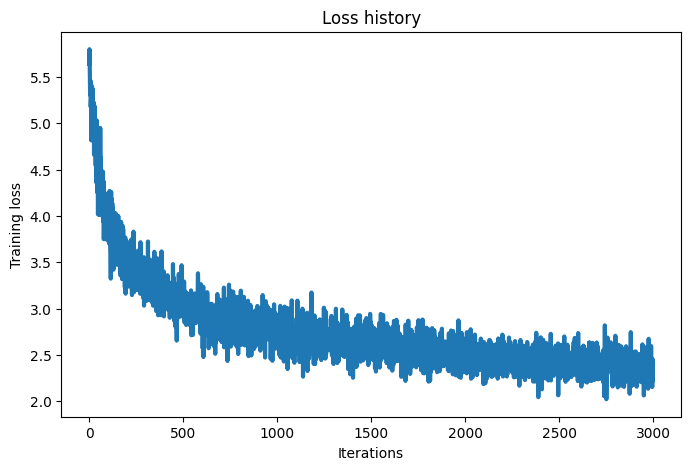

In [26]:
from model.LinearClassifier import LinearClassifier
from visualization.utils import visualize_loss
import itertools as it
lr = 1e-7
reg = 1

classifier = LinearClassifier(softmax_ce_forward_backward)
#
# TODO : ajouter code à la fonction train.  Si tout fonctionne bien, la courbe de la loss devrait décroitre
#
train_loss_history = classifier.train(X_train, y_train, learning_rate=lr, reg=reg, num_iter=3000, verbose = True)

y_train_pred = classifier.predict(X_train)
y_val_pred = classifier.predict(X_val)

acc_train = np.mean(y_train == y_train_pred)
acc_val = np.mean(y_val == y_val_pred)

print('train vs val acc %f / %f' %(acc_train, acc_val))

visualize_loss(train_loss_history)

## Recherche d'hyper-paramètres

best validation accuracy achieved during cross-validation: 0.391000


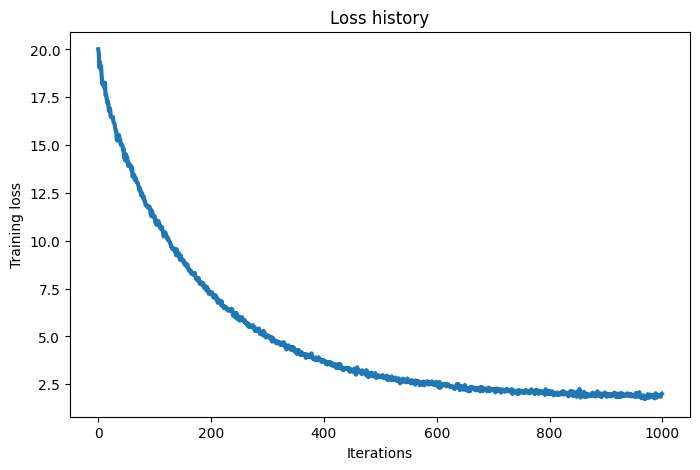

In [37]:
from model.LinearClassifier import LinearClassifier
from visualization.utils import visualize_loss
import itertools as it
results = {}
best_val = -1
best_reg = -1
best_lr = -1
best_softmax = None
learning_rates = np.linspace(1e-7, 1e-5, 5)
regularization_strengths = np.linspace(1e3, 1e7, 5)
best_loss_history = None
best_classifier = None

##############################################################################
# TODO: Utilisez l'ensemble de validation pour régler les hyper-paramètres   #
#  (force de régularisation et vitesse d'apprentissage). Vous devez          #
#  expérimenter différentes plages de valeurs pour les taux d'apprentissage  #
#  et les forces de régularisation; si tout va bien, avec num_iter = 1000    #
#  vous devriez obtenir une précision de classification supérieur à 0.38 sur #
#  l'ensemble de validation, et de 0.37 sur l'ensemble de test.              #
#  Mettre les résultats des meilleurs hyper-paramètres dans les variables    #
#  best_XYZ ci haut.                                                         #
##############################################################################
for lr in learning_rates:
    for reg in regularization_strengths:
        classifier = LinearClassifier(softmax_ce_forward_backward)
        train_loss_history = classifier.train(X_train, y_train, learning_rate=lr, reg=reg, num_iter=1000, verbose = False)

        y_train_pred = classifier.predict(X_train)
        y_val_pred = classifier.predict(X_val)

        acc_train = np.mean(y_train == y_train_pred)
        acc_val = np.mean(y_val == y_val_pred)
        
        if acc_val > best_val:
            best_val = acc_val
            best_reg = reg
            best_lr = lr
            best_loss_history = train_loss_history
            best_classifier = classifier

################################################################################
#                             FIN DE VOTRE CODE                                #
################################################################################
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

visualize_loss(best_loss_history)

In [38]:
# On évalue le modèle sur l'ensemble de test
y_test_pred = best_classifier.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('Test set accuracy: %f' % (test_accuracy) )

Test set accuracy: 0.384000


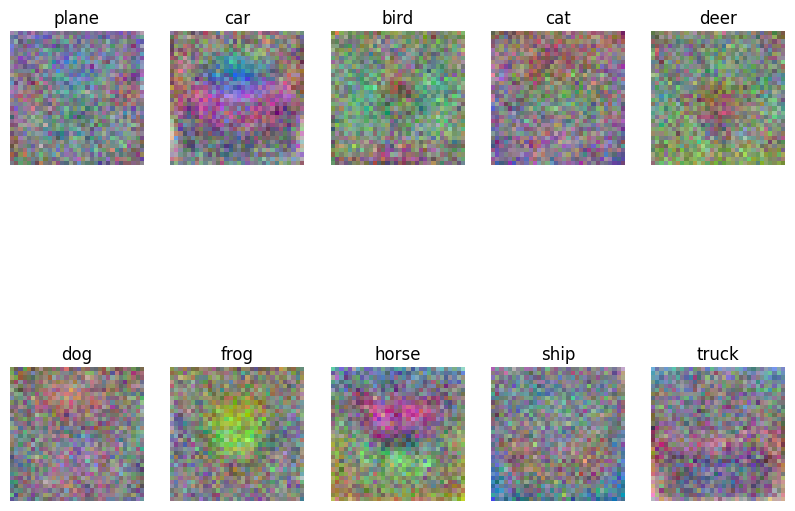

In [39]:
# Visualisation des poids appris pour chaque classe
w = best_classifier.W[:-1,:] # retire le biais
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Redimensionne les poids pour qu'ils soient entre 0 et 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])